Transfer learning of labels from of Reyfman et al AJRCCM 2019 integrated object (GSE122960) onto dataset from Bharat et al STM 2020 (GSE158127).

- Subset Reyfman object on IPF samples
- exclude meaningless transcripts see [here](https://www.ncbi.nlm.nih.gov/genbank/acc_prefix/) and [here](https://www.ncbi.nlm.nih.gov/books/NBK21091/table/ch18.T.refseq_accession_numbers_and_mole/?report=objectonly), mitochondrial genes, and ribosomal genes 

In [1]:
import pathlib
import anndata
import scvi
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import sklearn.neighbors
import pynndescent
import numba
import warnings

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
torch.cuda.current_device()

0

### Load reference object - annotated Reyfman processed with b93 + SARS

In [6]:
reference = sc.read_h5ad('../../data/21scArches/reyfman_reprocessed/reyfman_reprocessed.h5ad')

In [7]:
scanvae = scvi.model.SCANVI.load('models/reyfman_on_reyfman_diff_ref_genomes.model', reference)

INFO     File models/reyfman_on_reyfman_diff_ref_genomes.model/model.pt already downloaded                         


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Subset on IPF samples

In [8]:
ipf_samples = reference.obs[reference.obs['sample'].str.startswith('IPF')]['sample'].unique().tolist()

In [9]:
reference = reference[reference.obs['sample'].isin(ipf_samples)]

### Subset on immune cells

In [10]:
keywords = ["MoAM", "monocytes", "TRAM"]
reference = reference[reference.obs['cell_type_pred'].str.contains('|'.join(keywords), case=False)]

## Remove meaningless genes 
### Remove transcripts with 'AC', 'AP', 'AL', 'AF', etc. prefix from list of genes. See [here](https://www.ncbi.nlm.nih.gov/genbank/acc_prefix/) and [here](https://www.ncbi.nlm.nih.gov/books/NBK21091/table/ch18.T.refseq_accession_numbers_and_mole/?report=objectonly). Also remove ribosomal genes and mitochondrial genes. 
These are "genes" are actually transcripts with prefixes like ACXXXXX, APXXXXXX, and ALXXXXXX.  Since these are not biologically significant genes, it makes sense to exclude them. However, we don't expect to find them expressed since they are uniquely detected in 3' chemistry.

In [11]:
# specify the prefix pattern
prefixes_to_remove = ['AC', 'AL', 'AP', 'AF', 'AD', 'BX', 'CR', 'FP', 'KF']

# specify tlhe pattern to match genes to remove
pattern_to_remove = '|'.join([f'{prefix}\d{{6}}\.\d' for prefix in prefixes_to_remove] + ['Z\d{5}\.\d', 'U\d{5}\.\d'])

In [12]:
# Create boolean masks for both conditions
pattern_mask = reference.raw.var.index.str.contains(pattern_to_remove, regex=True)
ribo_mito_mask = reference.raw.var.index.str.startswith(("RPS", "RPL", "MT-"))

# Create a combined mask 
combined_mask = (pattern_mask | ribo_mito_mask)

In [13]:
print(pattern_mask.sum())
print(ribo_mito_mask.sum())
print(combined_mask.sum())

7626
115
7741


In [14]:
# Create a new AnnData object with the filtered data
reference = anndata.AnnData(
    X=reference.raw.X[:, ~combined_mask],
    obs=reference.obs,
    var=reference.raw.var[~combined_mask],
    obsm=reference.obsm,
    uns=reference.uns
)

In [15]:
reference.layers["counts"] = reference.X.copy()

### Load Bharat dataset (GSE158127)

In [17]:
bharat = sc.read_h5ad('../../data/21scArches/bharat/GSE158127_02immune.h5ad')

### Remove Habermann dataset from integrated object and remove control samples

In [18]:
bharat = bharat[(bharat.obs.Study == "Bharat_et_al_2020") & (bharat.obs.Diagnosis == "COVID-19")]

### Remove meaningless genes
Same workflow as above.

In [19]:
# Create boolean masks for both conditions
pattern_mask = bharat.var.index.str.contains(pattern_to_remove, regex=True)
ribo_mito_mask = bharat.var.index.str.startswith(("RPS", "RPL", "MT-"))

# Create a combined mask using numpy.logical_or
combined_mask = (pattern_mask | ribo_mito_mask)

print(pattern_mask.sum())
print(ribo_mito_mask.sum())
print(combined_mask.sum())

316
13
329


In [20]:
# Create a new AnnData object with the filtered data
bharat = anndata.AnnData(
    X=bharat.X[:, ~combined_mask],
    obs=bharat.obs,
    var=bharat.var[~combined_mask],
)

In [21]:
bharat.layers["counts"] = bharat.X.copy()

### Save unnormalized data

In [22]:
bharat.write_h5ad('../../data/21scArches/bharat/bharat_raw_unnormalized.h5ad')

In [23]:
sc.pp.normalize_total(bharat, target_sum=1e4)
sc.pp.log1p(bharat)
bharat.raw = bharat # freeze the state in `.raw`

In [24]:
bharat.write_h5ad('../../data/21scArches/bharat/bharat_raw.h5ad')

In [25]:
scanvae.prepare_query_anndata(bharat, scanvae)

INFO     Found 94.55% reference vars in query data.                                                                


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


### Setup and train model

In [26]:
bharat.obs["pred_labels"] = scanvae.unlabeled_category_

In [27]:
bharat.obs['batch'] = (
    bharat.obs['Sample Name'].cat.codes 
    + reference.obs.batch.astype(int).max() 
    + 10
).astype(str).astype('category')

In [28]:
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [29]:
model = scvi.model.SCANVI.load_query_data(bharat, scanvae, accelerator='gpu')

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/data/_manager.py:216: UserWarning: Missing labels key ann_level_3. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [30]:
# model.train(max_epochs=500, **train_kwargs_surgery)

In [31]:
# model.save('models/reyfman_on_bharat.model')

In [32]:
model = scanvae.load('models/reyfman_on_bharat.model', bharat)

INFO     File models/reyfman_on_bharat.model/model.pt already downloaded                                           


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


### Get latent representation of model

In [33]:
bharat.obsm['X_scvi'] = model.get_latent_representation()

In [34]:
sc.pp.neighbors(bharat, use_rep='X_scvi')
sc.tl.umap(bharat, min_dist=0.3)

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/b1

In [35]:
sc.tl.leiden(bharat)

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


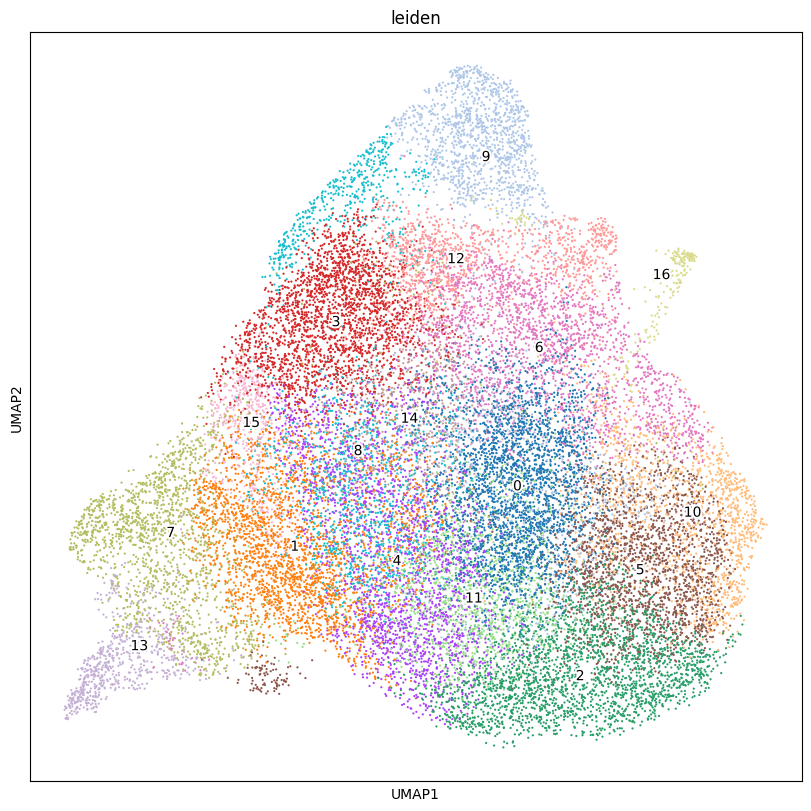

In [36]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    bharat, 
    color='leiden', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

### Get raw object
Raw counts are not preserved. Grab them again.

In [37]:
bharat_raw = sc.read_h5ad('../../data/21scArches/bharat/bharat_raw.h5ad')

In [38]:
bharat.raw = bharat_raw

Code below is from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/query_hlca_knn.html

In [39]:
reference_nn_index = pynndescent.NNDescent(reference.obsm['X_scvi'])

In [40]:
reference_nn_index.prepare()

In [41]:
ref_neighbors, ref_distances = reference_nn_index.query(bharat.obsm['X_scvi'])

In [42]:
# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)

In [43]:
@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

In [44]:
ref_cats = reference.obs.cell_type_pred.cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(reference.obs.cell_type_pred.cat.categories)[p]
bharat.obs["cell_type_pred"], bharat.obs["cell_type_uncertainty"] = p, u

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


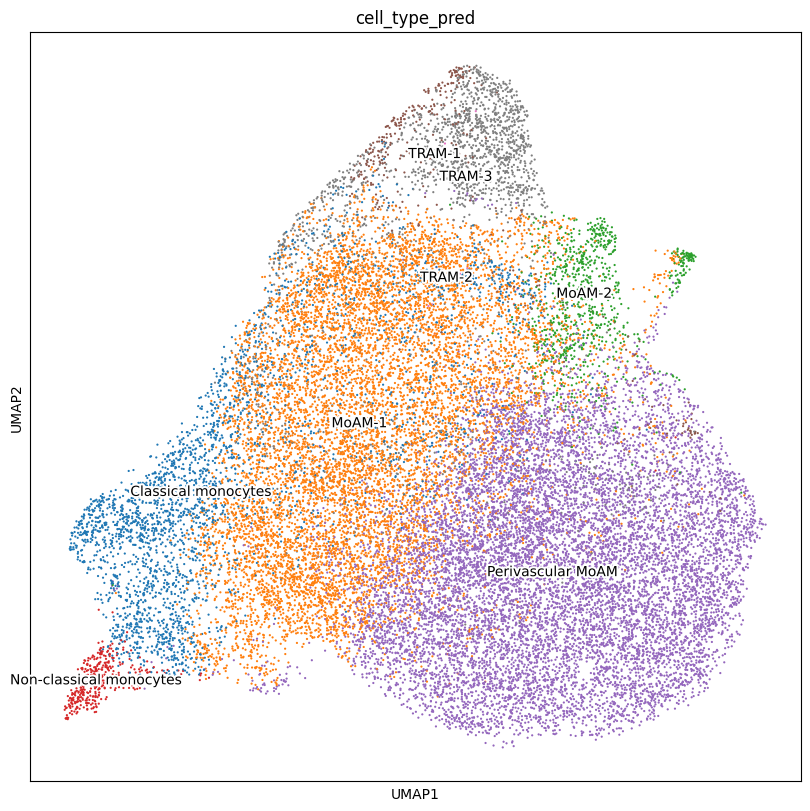

In [45]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    bharat, 
    color='cell_type_pred', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

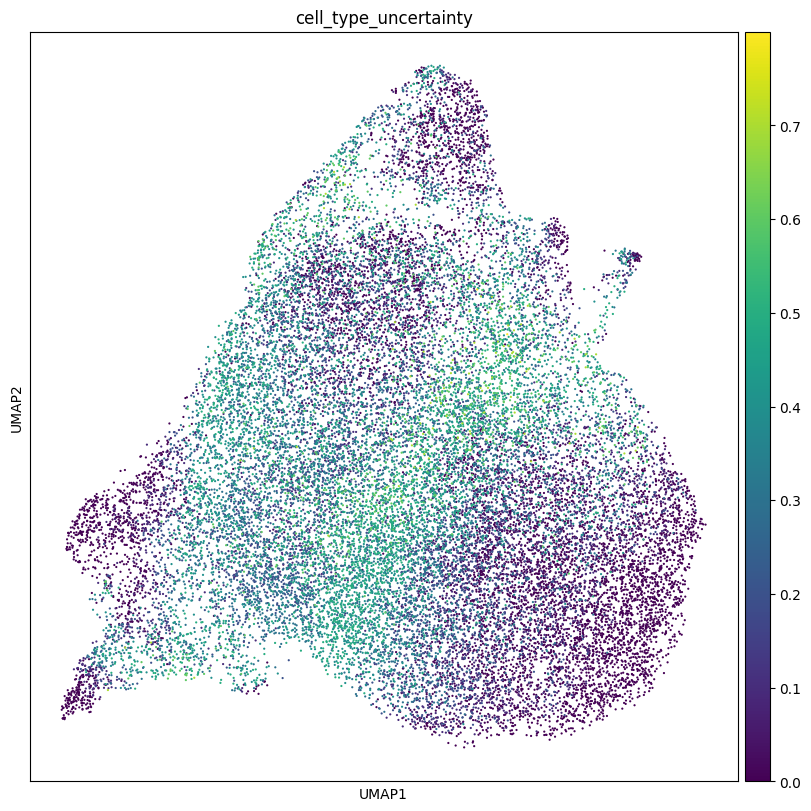

In [46]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    bharat, 
    color='cell_type_uncertainty', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

In [47]:
bharat_backup = bharat.copy()

### Get markers

In [48]:
def get_markers(
    adata,
    groupby,
    key="rank_genes_groups",
    p_val_cutoff=0.05,
    logfc_cutoff=0.5
):
    """\
    Extract markers from adata into Seurat-like table

    Extracts markers after they are computed by ``scanpy``. Produces Seurat-like
    table with fields
    ``"p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"``

    Calculates the percentage of cells that express a given gene
    in the target cluster (``pct.1`` field) and outside the cluster
    (``pct.2`` field) from ``adata.raw`` matrix.

    Parameters
    ----------
    adata
        Annotated data matrix.
    groupby
        ``adata.obs`` field used for marker calculation
    key
        ``adata.uns`` key that has computed markers
    p_val_cutoff
        Drop all genes with adjusted p-value greater than or equal to this
    logfc_cutoff
        Drop all genes with average logFC less than or equal to this

    Returns
    -------
    Returns a pandas dataframe with above listed columns, optionally
    subsetted on the genes that pass the cutoffs.
    ``p_val`` field is a copy of adjusted p-value field.

    Example
    -------
    >>> sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", n_genes=200)
    >>> markers = sc_utils.get_markers(adata, "leiden")
    >>> markers.to_csv("markers.csv")
    """
    markers = pd.concat([
        pd.DataFrame(adata.uns[key]["names"]).melt(),
        pd.DataFrame(adata.uns[key]["pvals_adj"]).melt(),
        pd.DataFrame(adata.uns[key]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > logfc_cutoff, ]
    markers = markers.loc[markers.p_val_adj < p_val_cutoff, ]
    markers["pct.1"] = pd.Series(dtype=float)
    markers["pct.2"] = pd.Series(dtype=float)

    for cluster in markers.cluster.unique():
        cells = adata.obs[groupby] == cluster
        in_cluster_selector = markers.cluster == cluster
        genes = markers.gene[in_cluster_selector]
        in_cluster = np.sum(adata.raw[cells, genes].X > 0, axis=0).A1 / cells.sum()
        markers.loc[in_cluster_selector, "pct.1"] = in_cluster
        other_cells = adata.obs[groupby] != cluster
        other_clusters = np.sum(adata.raw[other_cells, genes].X > 0, axis=0).A1 / other_cells.sum()
        markers.loc[in_cluster_selector, "pct.2"] = other_clusters

    markers["p_val"] = markers.p_val_adj
    markers = markers.loc[:, ["p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"]]
    return markers

In [49]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    sc.tl.rank_genes_groups(bharat, "cell_type_pred", method="t-test", n_genes=200)

In [50]:
markers = get_markers(bharat, "cell_type_pred")

In [51]:
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False], inplace=True)

In [52]:
markers.groupby("cluster").head(2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
7,4.853412e-278,3.858459,0.417607,0.068294,4.853412e-278,Classical monocytes,S100A12
1,0.000000e+00,3.093659,0.726217,0.244216,0.000000e+00,Classical monocytes,FCN1
213,7.930088e-160,2.534785,0.122389,0.026858,7.930088e-160,MoAM-1,CCL7
368,9.989607e-43,2.101956,0.039539,0.010678,9.989607e-43,MoAM-1,SPINK1
422,1.179911e-93,5.128539,0.445755,0.026866,1.179911e-93,MoAM-2,CHI3L1
597,2.934173e-41,4.547003,0.235849,0.015043,2.934173e-41,MoAM-2,MMP7
671,3.620104e-20,5.572751,0.222798,0.007847,3.620104e-20,Non-classical monocytes,CX3CR1
693,9.364642e-16,5.281508,0.178756,0.008098,9.364642e-16,Non-classical monocytes,CD79B
806,0.000000e+00,3.395296,0.508350,0.095957,0.000000e+00,Perivascular MoAM,SLC40A1
987,1.846051e-133,2.850745,0.079936,0.012766,1.846051e-133,Perivascular MoAM,IL2RA


### Save

In [53]:
bharat.write_h5ad('../../data/21scArches/reyfman_on_bharat/reyfman_on_bharat.h5ad')

In [54]:
markers.to_csv('../../data/21scArches/reyfman_on_bharat/reyfman_on_bharat-markers.csv')

In [55]:
bharat.obs.to_csv('../../data/21scArches/reyfman_on_bharat/reyfman_on_bharat-metadata.csv')